In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from tqdm.notebook import trange, tqdm

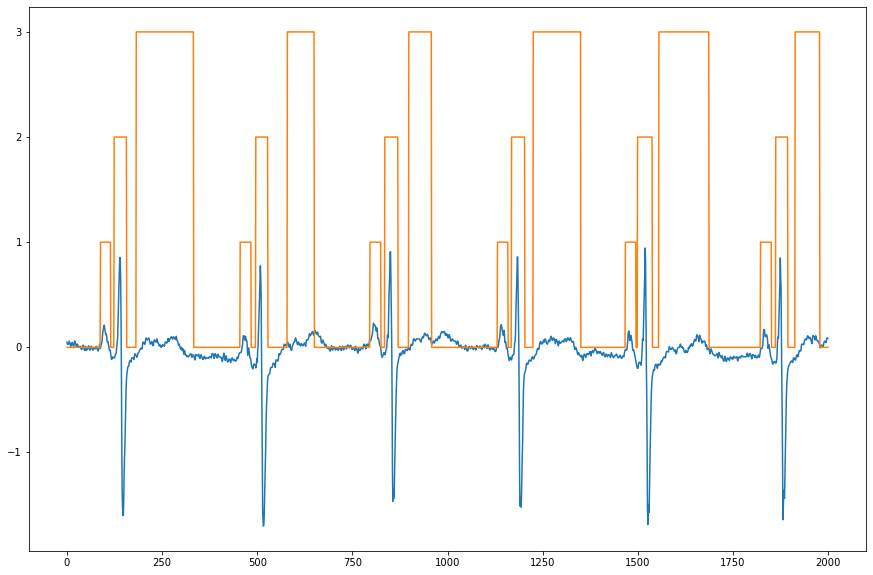

In [5]:
def load_data():
    samples = []
    annotations = []
    for i in range(1,74):
        if i < 15:
            s = pd.read_csv('dataset/samples_'+str(i)+'.csv').iloc[1:,1].to_numpy(dtype='float64')
            a = pd.read_csv('dataset/annotation_'+str(i)+'.csv').iloc[0:,0].to_numpy(dtype='float64')
            samples.append(s)
            annotations.append(a)
        elif i > 15:
            s = pd.read_csv('dataset/samples_'+str(i)+'.csv').iloc[1:,1].to_numpy(dtype='float64')
            a = pd.read_csv('dataset/annotation_'+str(i)+'.csv').iloc[0:,0].to_numpy(dtype='float64')
            samples.append(s)
            annotations.append(a)
    return samples, annotations

samples, annotations = load_data()

plt.figure(figsize=(15, 10))
plt.plot(list(range(2000)), samples[0][:2000], label = 'X')
plt.plot(list(range(2000)), annotations[0][:2000], label = 'Y')
plt.show()

In [6]:
class DataGenerator:
    def __init__(self, samples, annotations):
        self.samples = samples
        self.annotations = annotations
    
    def split_to_windows(self, X, Y, window_size):
        result_X = []
        result_Y = []
        enc = OneHotEncoder(handle_unknown='ignore')
        Y_hot = enc.fit_transform(np.asmatrix(Y).T).toarray()
        for i in range(0, len(X) - window_size + 1):
            x = []
            y = []
            for j in range(window_size):
                if j == window_size - 1:
                    x.append(X[i + j])
                else:
                    x.append(X[i + j])
                    x.append(Y[i + j])
                
            result_X.append(x)
            result_Y.append(Y_hot[i+window_size-1])
        return result_X, result_Y
    
    def split_train_test(self, window_size, test_size=0.2):
        X = []
        Y = []
        for i in range(len(self.samples)):
            s = self.samples[i]
            a = self.annotations[i]
            s, a = self.split_to_windows(s, a, window_size)
            X = X + s
            Y = Y + a
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=2021)
        return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [7]:
# Elman

from nnlib.elman import Elman

dg = DataGenerator(samples, annotations)
for window_size in [5, 11, 21]:
    epochs = 5
    X_train, X_test, y_train, y_test = dg.split_train_test(window_size = window_size)
    model = Elman(X_train.shape[1], window_size, y_train.shape[1])
    # Train model
    for _ in trange(epochs):
        for i, x in enumerate(X_train):
            model.propagate_forward(x)
            model.propagate_backward(y_train[i])
            
    # Accuracy for Train dataset
    prediction = []
    true_y = []
    for i, x in enumerate(X_train): 
        output = model.propagate_forward(x)
        prediction.append(np.argmax(output))
        true_y.append(np.argmax(y_train[i]))
    print('Train Accuracy for window ', window_size, ' = ', accuracy_score(prediction, true_y))
    
    # Accuracy for Test dataset
    prediction = []
    true_y = []
    for i, x in enumerate(X_test): 
        output = model.propagate_forward(x)
        prediction.append(np.argmax(output))
        true_y.append(np.argmax(y_test[i]))
    print('Test Accuracy for window ', window_size, ' = ', accuracy_score(prediction, true_y))
    print('\n')

  0%|          | 0/5 [00:00<?, ?it/s]

Train Accuracy for window  5  =  0.9688626836985177
Test Accuracy for window  5  =  0.9696525355789589




  0%|          | 0/5 [00:00<?, ?it/s]

Train Accuracy for window  11  =  0.9733761381088196
Test Accuracy for window  11  =  0.9735698222904783




  0%|          | 0/5 [00:00<?, ?it/s]

Train Accuracy for window  21  =  0.655342387723729
Test Accuracy for window  21  =  0.6537004502031405




In [8]:
# Narx
from nnlib.narx import Narx




def get_delayed_input(i, X, x_delay):
    delayed_input = np.array([])
    if i - (x_delay - 1) < 0:
        j = i
        while j >= 0:
            delayed_input = np.concatenate((delayed_input, X[j]))
            j = j - 1
        reminders = [0] * ((x_delay - 1) - i) * X[0].shape[0]
        delayed_input = np.concatenate((delayed_input, reminders))
    else:
        for j in range(x_delay):
            delayed_input = np.concatenate((delayed_input, X[i - j]))
    return delayed_input



# step = y_train.shape[1]
def update_last_outputs(output, last_ys, step):
    for i in range(0, last_ys.size - step, step):
        last_ys[i: i+step] = last_ys[i+step : i + (2*step)]
    last_ys[last_ys.size-step:] = output
    return last_ys



dg = DataGenerator(samples, annotations)
for window_size in [5, 11, 21]:
    epochs = 5
    X_train, X_test, y_train, y_test = dg.split_train_test(window_size = window_size)
    
    shape, x_delay, y_delay = (X_train.shape[1], window_size, y_train.shape[1]), 3,3
    model = Narx(shape, x_delay, y_delay)
    delayed_output = np.zeros(y_delay * y_train.shape[1])
    # Train model
    for _ in trange(epochs):
        for i, _ in enumerate(X_train):
            delayed_input = get_delayed_input(i, X_train, x_delay)
            inp = np.concatenate((delayed_input, delayed_output))
            output = model.propagate_forward(inp)
            model.propagate_backward(y_train[i])
            delayed_output = update_last_outputs(output, delayed_output, y_train.shape[1])
    
    
    # Accuracy for Train dataset
    prediction = []
    true_y = []
    delayed_output = np.zeros(y_delay * y_train.shape[1])
    for i, x in enumerate(X_train): 
        delayed_input = get_delayed_input(i, X_train, x_delay)
        inp = np.concatenate((delayed_input, delayed_output))
        output = model.propagate_forward(inp)
        prediction.append(np.argmax(output))
        true_y.append(np.argmax(y_train[i]))
        delayed_output = update_last_outputs(output, delayed_output, y_train.shape[1])
        
    print('Train Accuracy for window ', window_size, ' = ', accuracy_score(prediction, true_y))
    
    # Accuracy for Test dataset
    prediction = []
    true_y = []
    delayed_output = np.zeros(y_delay * y_train.shape[1])
    for i, x in enumerate(X_test): 
        delayed_input = get_delayed_input(i, X_train, x_delay)
        inp = np.concatenate((delayed_input, delayed_output))
        output = model.propagate_forward(inp)
        prediction.append(np.argmax(output))
        true_y.append(np.argmax(y_train[i]))
        delayed_output = update_last_outputs(output, delayed_output, y_train.shape[1])
    print('Test Accuracy for window ', window_size, ' = ', accuracy_score(prediction, true_y))
    print('\n')

  0%|          | 0/5 [00:00<?, ?it/s]

Train Accuracy for window  5  =  0.9733045091465974
Test Accuracy for window  5  =  0.9724070356234968




  0%|          | 0/5 [00:00<?, ?it/s]

Train Accuracy for window  11  =  0.9691785048266783
Test Accuracy for window  11  =  0.968935114085125




  0%|          | 0/5 [00:00<?, ?it/s]

Train Accuracy for window  21  =  0.7973279482815416
Test Accuracy for window  21  =  0.796173273306248


